In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
import augtistic as aug
import augtistic.layers

In [2]:
(ds_train_cifar, ds_test_cifar), ds_info_cifar = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
input_shape_cifar = ds_info_cifar.features["image"].shape # (28, 28, 1)
ds_info_cifar

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)

In [3]:
ds_info_cifar.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

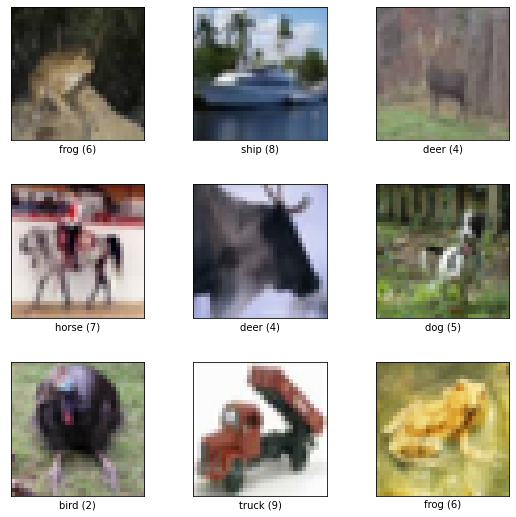

In [4]:
fig = tfds.show_examples(ds_train_cifar, ds_info_cifar)

In [5]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., int(label)
## TRAIN DATASET PIPELINE
ds_train_cifar = ds_train_cifar.map(normalize_img, 
                                    num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train_cifar = ds_train_cifar.batch(10)
ds_train_cifar = ds_train_cifar.cache()
ds_train_cifar = ds_train_cifar.prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
IMAGE_SHAPE = input_shape_cifar
aug_input = tf.keras.layers.Input(IMAGE_SHAPE)
aug_output = tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal")(aug_input)
aug_output = aug.layers.RandomGaussian2D(0.3)(aug_output)
aug_output = tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.01, width_factor=0.0015)(aug_output)
aug_output = tf.keras.layers.experimental.preprocessing.RandomContrast(0.075)(aug_output)
aug_output = aug.layers.RandomSaturation(0.01)(aug_output)
aug_output = aug.layers.RandomBrightness(0.15)(aug_output)
aug_output = aug.layers.RandomHue(0.25)(aug_output)
aug_output = aug.layers.RandomDenseImageWarp(0.4, (0.1,0.4))(aug_output)
aug_output = aug.layers.RandomBlendGrayscale(0.2, (0.1, 0.3))(aug_output)
aug_output = aug.layers.RandomCutout(1, rounds=2)(aug_output)
aug_output = aug.layers.RandomCutout(4, rounds=2)(aug_output)
aug_output = aug.layers.RandomCutout(8, rounds=2)(aug_output)
aug_output = aug.layers.RandomCutout(2, rounds=10)(aug_output)
aug_output = tf.keras.layers.experimental.preprocessing.RandomZoom((-0.01,0.1), width_factor=(-0.15,0.05))(aug_output)
aug_output = tf.keras.layers.experimental.preprocessing.RandomTranslation((-0.1, 0.05), (-0.1, 0.15))(aug_output)                                                             
aug_model_1 = tf.keras.Model(aug_input, aug_output, name="augmenter_1")

In [7]:
aug_input = tf.keras.layers.Input(IMAGE_SHAPE)
aug_output = tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal")(aug_input)
aug_output = aug.layers.RandomMeanFilter2D(filter_factor=10)(aug_output)
aug_output = tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.15, width_factor=0.05)(aug_output)
aug_output = tf.keras.layers.experimental.preprocessing.RandomContrast(0.1)(aug_output)
aug_output = aug.layers.RandomSaturation(0.2)(aug_output)
aug_output = aug.layers.RandomBrightness(0.05)(aug_output)
aug_output = aug.layers.RandomHue(0.1)(aug_output)
aug_output = aug.layers.RandomSharpness(0.4, (0.1,0.99))(aug_output)
aug_output = aug.layers.RandomGrayscale(0.1)(aug_output)
aug_output = aug.layers.RandomCutout(2)(aug_output)
aug_output = aug.layers.RandomCutout(8)(aug_output)
aug_output = tf.keras.layers.experimental.preprocessing.RandomZoom((-0.15,0.1), width_factor=(-0.05,0.1))(aug_output)
aug_output = tf.keras.layers.experimental.preprocessing.RandomTranslation((-0.05, 0.1), (-0.15, 0.05))(aug_output) 
aug_output = aug.layers.RandomHSVinYIQ(0.5, 0.4, 0.8, 0.3, 0.8)(aug_output)
aug_model_2 = tf.keras.Model(aug_input, aug_output, name="augmenter_2")

In [8]:
batch, labels = next(iter(ds_train_cifar))
batch.numpy().shape, labels.numpy()

((10, 32, 32, 3), array([7, 4, 4, 8, 5, 6, 2, 9, 6, 6], dtype=int32))

In [9]:
ds_info_cifar.features["label"].int2str(labels.numpy()[0])

'horse'

(10, 32, 32, 3)

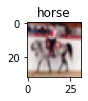

In [10]:

plt.figure(figsize=(1,1))
plt.title(ds_info_cifar.features["label"].int2str(labels.numpy()[0]))
plt.imshow(tf.transpose(batch, perm=[0,1,2,3]).numpy()[0])
batch.numpy().shape

In [11]:
batch_data_a = tf.clip_by_value(aug_model_1(batch.numpy().copy()), 0., 1.).numpy()
batch_data_b = tf.clip_by_value(aug_model_2(batch.numpy().copy()), 0., 1.).numpy()

[INFO]	 Example Batch Data after Preprocessing Model


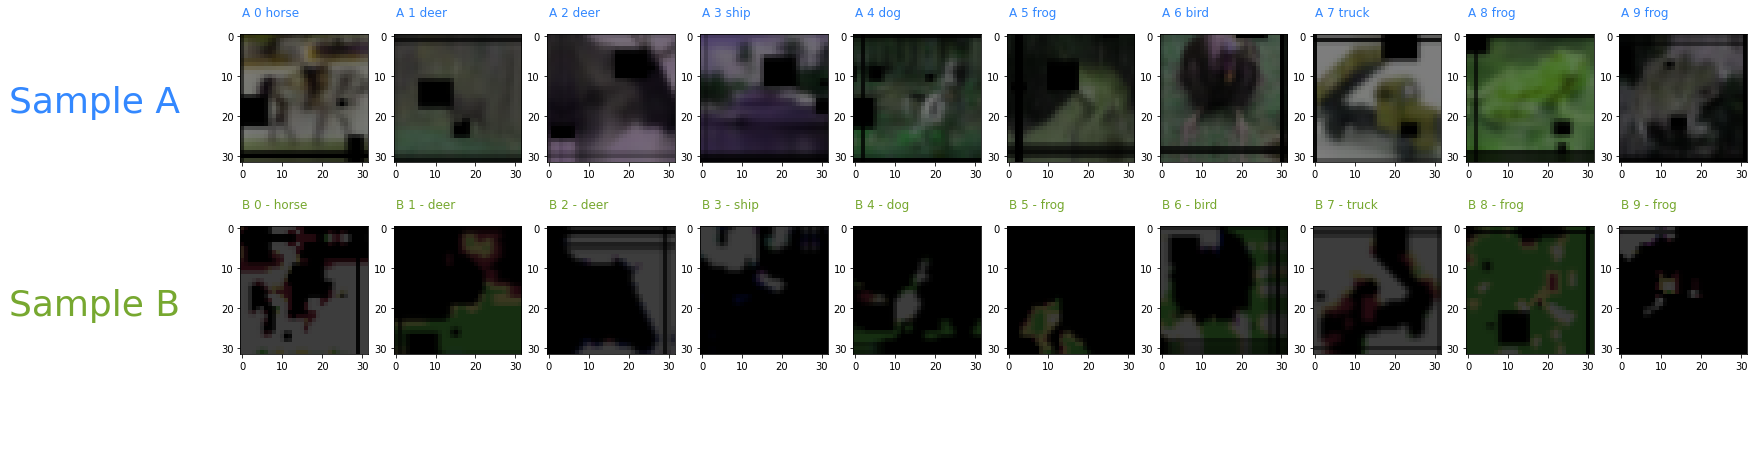

In [12]:
plt.rcParams["figure.figsize"] = (27,10)
plt.figure()

for i in range(0, 10, 1):
    plt.subplot(3, 10, i+1)
    img = batch_data_a[i].astype("float32")
    plt.imshow((img)/2)
    plt.text(0., -5, f"A {i} {ds_info_cifar.features['label'].int2str(labels.numpy()[i])}", color="#3388FF", fontsize=12)
    plt.subplot(3, 10, i+11)  
    img = batch_data_b[i].astype("float32")    
    plt.imshow((img)/2)
    plt.text(0., -5., f"B {i} - {ds_info_cifar.features['label'].int2str(labels.numpy()[i])}", color="#77A830", fontsize=12)
plt.annotate("Sample A", xy=(0.005,0.75), xycoords="figure fraction", fontsize=36, color="#3388FF")
plt.annotate("Sample B", xy=(0.005,0.3), xycoords="figure fraction", fontsize=36, color="#77A830")

print("[INFO]\t Example Batch Data after Preprocessing Model")

In [13]:
batch, labels = next(iter(ds_train_cifar))
batch_data_a = tf.clip_by_value(aug_model_1(batch.numpy().copy()), 0., 1.).numpy()
batch_data_b = tf.clip_by_value(aug_model_2(batch.numpy().copy()), 0., 1.).numpy()

[INFO]	 Example Batch Data after Preprocessing Model


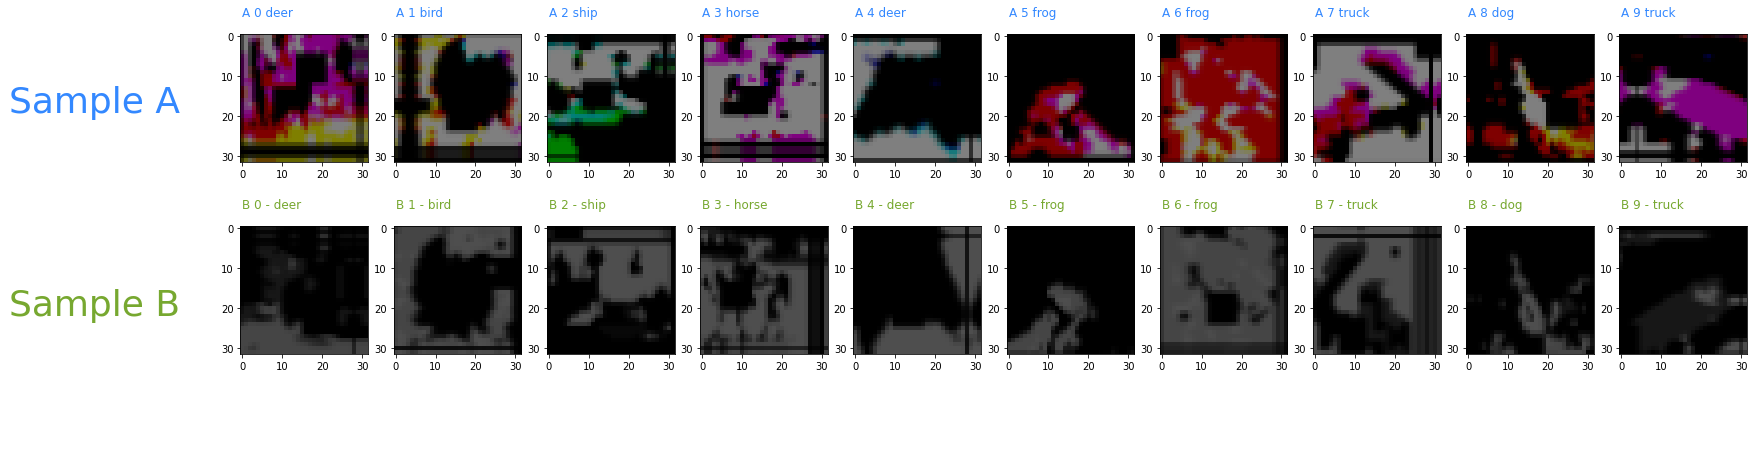

In [14]:
plt.rcParams["figure.figsize"] = (27,10)
plt.figure()

for i in range(0, 10, 1):
    plt.subplot(3, 10, i+1)
    img = batch_data_a[i].astype("float32")
    plt.imshow((img)/2)
    plt.text(0., -5, f"A {i} {ds_info_cifar.features['label'].int2str(labels.numpy()[i])}", color="#3388FF", fontsize=12)
    plt.subplot(3, 10, i+11)  
    img = batch_data_b[i].astype("float32")    
    plt.imshow((img)/2)
    plt.text(0., -5., f"B {i} - {ds_info_cifar.features['label'].int2str(labels.numpy()[i])}", color="#77A830", fontsize=12)
plt.annotate("Sample A", xy=(0.005,0.75), xycoords="figure fraction", fontsize=36, color="#3388FF")
plt.annotate("Sample B", xy=(0.005,0.3), xycoords="figure fraction", fontsize=36, color="#77A830")

print("[INFO]\t Example Batch Data after Preprocessing Model")